In [1]:
import sys
import os

# 获取当前工作目录
current_dir = os.getcwd()

# 获取父目录（即 python_dir）
project_dir = os.path.dirname(current_dir)
sys.path.append(project_dir)


import numpy as np
import cupy as cp
import mytorch as torch
import mytorch.ops as ops
import mytorch.nn as nn
import mytorch.optim as optim
import mytorch.data as data
from mytorch.array_device import *
from mytorch.array_api import array_api
import mytorch.perfomance as pf

In [2]:
# pooling层测试
x_array = np.array([[[1, 2, 3], [4, 5, 6], [7, 8, 9]]]).reshape(1, 1, 3, 3)
print(x_array)
x = torch.Tensor(x_array)
y = nn.MaxPooling2D(kernel_size=2, stride=1)(x)
print(y)
y.backward()
print(x.shape)
print(x.grad.shape)
print(x.grad)


[[[[1 2 3]
   [4 5 6]
   [7 8 9]]]]
[[[[5 6]
   [8 9]]]]
(1, 1, 3, 3)
(1, 1, 3, 3)
[[[[0. 0. 0.]
   [0. 1. 1.]
   [0. 1. 1.]]]]


In [3]:

# 定义一个全连接网络
class Model(nn.Module):
    def __init__(self, device = cpu()):
        super(Model, self).__init__()
        self.block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784,100,device=device),
            nn.ReLU(),
            nn.Linear(100,10,device=device),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.block(x)

In [4]:
batch_size=100
epochs=10
net = Model()
optimizer=optim.Adam(net.parameters(),lr=0.001,weight_decay=0.001)
criterion= nn.SoftmaxLoss()

In [5]:
#测试跑通模型
x_array = np.random.rand(1,1,28,28)
x = torch.Tensor(x_array)
net(x)

mytorch.Tensor([[1.5829142  0.86624504 0.         1.27943697 1.60815819 0.
  0.         0.         0.65410539 1.10642133]])

In [6]:
import os
# 获取根目录 这里读的数据是我们项目自带的MNIST数据集
root_dir= os.path.abspath(os.path.join(project_dir, os.pardir))
root_dir

# 加载训练数据集
train_dataset = data.MNISTDataset(\
        f"{root_dir}/data/MNIST/train-images-idx3-ubyte.gz",
        f"{root_dir}/data/MNIST/train-labels-idx1-ubyte.gz")

# 训练集装入装载器，方便打乱和批量计算
train_dataloader = data.DataLoader(\
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True)

# 测试集同理
test_dataset = data.MNISTDataset(\
        f"{root_dir}/data/MNIST/t10k-images-idx3-ubyte.gz",
        f"{root_dir}/data/MNIST/t10k-labels-idx1-ubyte.gz")
test_dataloader = data.DataLoader(\
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=True)

EPOCH 0: avg_accuracy=0.8153333333333334, avg_loss=0.582393604755402
EPOCH 1: avg_accuracy=0.8575333333333334, avg_loss=0.41236512789726265
EPOCH 2: avg_accuracy=0.8671833333333333, avg_loss=0.37474244120915734
EPOCH 3: avg_accuracy=0.8710166666666667, avg_loss=0.3568275328954063
EPOCH 4: avg_accuracy=0.9258666666666666, avg_loss=0.22367526583671535
EPOCH 5: avg_accuracy=0.9704666666666667, avg_loss=0.11159736347198487
EPOCH 6: avg_accuracy=0.9725166666666667, avg_loss=0.10401019418636949
EPOCH 7: avg_accuracy=0.9742, avg_loss=0.09701424427032468
EPOCH 8: avg_accuracy=0.9753166666666667, avg_loss=0.09394233794609705
EPOCH 9: avg_accuracy=0.9761333333333333, avg_loss=0.09054764012893032


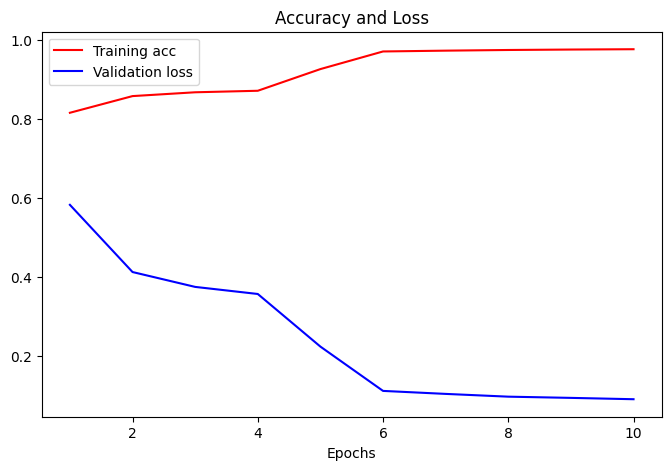

In [7]:
# 创建一个性能展示对象，再也不用手动画图
pfm = pf.Performance()
# 迭代
for epoch in range(epochs):
    # 一些计算参数
    total_loss = 0
    total_rights = 0
    total_examples = 0
    total_batches = 0
    # 从装载器取出数据
    for input,label in train_dataloader:
        # 将模型设置为训练模式
        # （实际上训练模式和评估模式的区别只在于部分网络层的计算规则）
        net.train()
        # 梯度清0
        optimizer.reset_grad()
        # 前向计算网络预测的答案
        # input.to('gpu')
        # label.to('gpu')
        pred = net(input)
        # 利用损失函数计算损失
        loss = criterion(pred,label)
        # 根据构建好的计算图反向传播
        loss.backward()
        # 利用优化器更新所有参数
        optimizer.step()
        # 取出预测的标签
        label_pred = np.argmax(pred.numpy(),axis=1)
        # 计算出正确的标签个数
        rights = np.equal(label_pred, label.numpy()).sum()

        # 每一个batch做一次更新
        total_loss += loss.numpy()
        total_rights += rights
        total_batches += 1
        total_examples += input.shape[0]
    
    # 计算平均损失
    avg_loss = total_loss / total_batches
    # 计算平均准确率
    avg_accuracy = total_rights / total_examples
    # 更新性能展示对象
    pfm.update_in_train(avg_accuracy,avg_loss)
    # 打印损失和准确率
    print(f"EPOCH {epoch}: {avg_accuracy=}, {avg_loss=}")
# 展示损失曲线
pfm.graph()

TEST SCORE: avg_accuracy=0.972, avg_loss=0.09850341401100163


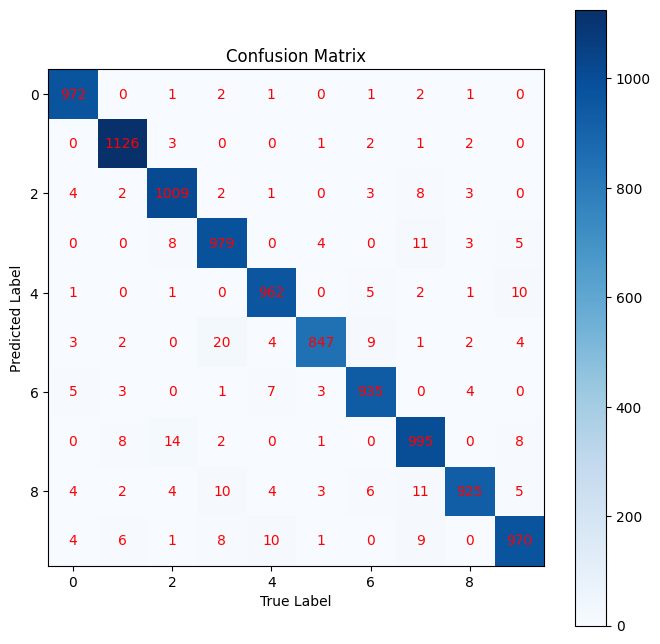

In [8]:
# 与训练类似，不再给出详细注释
total_loss = 0
total_rights = 0
total_examples = 0
total_batches = 0
for input,label in test_dataloader:
    net.eval()

    pred = net(input)
    loss = criterion(pred,label)
    label_pred = np.argmax(pred.numpy(),axis=1)
    rights = np.equal(label_pred, label.numpy()).sum()

    total_loss += loss.numpy()
    total_rights += rights
    total_batches += 1
    total_examples += input.shape[0]
    pfm.update_in_test(label.numpy(), label_pred)
    
avg_loss = total_loss / total_batches
avg_accuracy = total_rights / total_examples

print(f"TEST SCORE: {avg_accuracy=}, {avg_loss=}")

# 画出混淆矩阵
pfm.matrix(8)